<a href="https://colab.research.google.com/github/alejandro-cermeno/2021_Market_Timing-Cermeno/blob/main/arima_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### El modelo ARIMA de Box and Jenkins (1970)

Alejandro Cermeño 

06/2021

## Procedimientos preliminares



1.   Se importan las librerías necesarias
2.   Se importan las series de precios
3.   Se calcula el logaritmo de los retornos
4.   Estadísticos descriptivos
5.   Se configura el output en ${\LaTeX}$

In [3]:
# Configuración premiliminar

    # Librerias necesarias
import os
import pandas as pd
import numpy as np
from IPython.display import Image

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import pyplot
import math

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import  mean_squared_error
from sklearn.model_selection import train_test_split

from google.colab import drive

    # Directorio 
#drive.mount('/content/drive')

#os.chdir('/content/drive/MyDrive/TESIS/2021_Market_Timing-Cermeño/Code')

# Obtencion de datos
ruta_git = 'https://git.io/Jnovh'
series = pd.read_excel(ruta_git, sheet_name = 'source', index_col = 0)
series.head()

# Transformacion a retornos logarítmicos
logret_series = (100 * (np.log(series) - np.log(series.shift(1))))
logret_series.tail()

# Tabla de estadisticos descriptivos
descriptivos = pd.concat([logret_series.describe()\
                          .loc[['count','std', 'min', 'max']].T, 
                          series.skew().rename('skew'),series.kurt().\
                          rename('kurt')], axis=1).round(2)
    # Se agregan las fechas de inicio
fecha_inicio = logret_series.apply(lambda logret_series: logret_series.first_valid_index())
fecha_inicio = pd.DataFrame(fecha_inicio, columns=['Fecha Inicio'])
    # Se agregan las fechas de fin
fecha_fin = logret_series.apply(lambda logret_series: logret_series.last_valid_index())
fecha_fin = pd.DataFrame(fecha_fin, columns=['Fecha Fin'])

descriptivos = pd.concat([fecha_inicio, fecha_fin, descriptivos], axis = 1)

    # Se muestra la tabla resultante
display(descriptivos)
print('')
print('')
print('LaTeX')
print('')
print(descriptivos.to_latex()) # Se configura el output a LaTeX

,Fecha Inicio,Fecha Fin,count,std,min,max,skew,kurt
mexbol,1994-03-31,2021-05-31,7088.0,1.40,-14.31,12.15,0.04,-1.65
spblpgpt,2002-02-07,2021-05-31,5038.0,1.34,-13.29,12.82,-0.58,-0.96
ipsa,1990-08-09,2021-05-31,8038.0,1.14,-15.22,11.80,0.28,-1.41




LaTeX

\begin{tabular}{lllrrrrrr}
\toprule
{} & Fecha Inicio &  Fecha Fin &   count &   std &    min &    max &  skew &  kurt \\
\midrule
mexbol   &   1994-03-31 & 2021-05-31 &  7088.0 &  1.40 & -14.31 &  12.15 &  0.04 & -1.65 \\
spblpgpt &   2002-02-07 & 2021-05-31 &  5038.0 &  1.34 & -13.29 &  12.82 & -0.58 & -0.96 \\
ipsa     &   1990-08-09 & 2021-05-31 &  8038.0 &  1.14 & -15.22 &  11.80 &  0.28 & -1.41 \\
\bottomrule
\end{tabular}



## **Gráficos**

In [ ]:
def grafico(df):
  # Numero de filas y columnas
  nrows = math.ceil(df.shape[1] / 2) # Cantidad de series entre 2
  ncols = 2
  fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))
  for col, ax in zip(df.columns, axes.flatten()):
    ax.plot(df.index, df[col], c = 'navy', linewidth = 0.5)
    ax.set_title(col, fontsize=15)

Precios

In [ ]:
grafico(series)

Logaritmo de los retornos

In [ ]:
grafico(logret_series)

## **Pruebas de raíz unitaria**

Se utiliza la librería arch de [Sheppard (2021)](https://(https://arch.readthedocs.io/en/latest/)) 

In [ ]:
%%capture
#!pip install arch
import arch

Prueba de Dickey-Fuller Aumentada (ADF)

In [ ]:
arch.unitroot.ADF(method='AIC')

Prueba de Elliott, Rothenberg and Stock (ADF-GLS)

In [ ]:
arch.unitroot.DFGLS(method='AIC')

In [ ]:
nrows = math.ceil(series.shape[1] / 2) # Cantidad filas y columnas
paises = ['(a) Mexico', '(b) Peru', '(c) Chile']
fig, axes = plt.subplots(nrows, ncols=2, figsize=(15, 8))

# i fila
# j columna

for i in range(2):                # Número de fila
  for j in range(nrows):          # Número de columna
    #for k in range(len(paises)):  # Serie
    axes[i,j].plot(logret_series.iloc[:, i], c = 'navy', linewidth = 0.4)


In [ ]:
# Autocorrelograma

logret_spblpgpt = logret_series.iloc[:,1].dropna()
logret_spblpgpt = logret_spblpgpt[0:20] # ¡¡¡¡CAMBIAR!!!!

# Gráfico de Autocorrelación y Autocorrelación Parcial

for i in range(len(logret_series)):
  fig = plt.figure(figsize=(10,6))
  ax1 = fig.add_subplot(211)
  # Grafico ACF
  fig = sm.graphics.tsa.plot_acf((logret_series[i]),lags=25,ax=ax1, 
                                 title ='Autocorrelation '+pais[i])
  ax2 = fig.add_subplot(212)
  # Grafico PACF
  fig = sm.graphics.tsa.plot_pacf(logret_series[i].dropna(),lags=25,ax=ax2, 
                                  title ='Autocorrelacion Parcial')

In [ ]:
# Inspeccion de estacionariedad para precios

pais = ['MEXICO', 'PERU', 'CHILE']

      # Prueba ADF 
def prueba_adfuller(df):

  '''Esta función configura el formato del output de la función adfuller()'''

  for i in range(len(series)):
    print('Para', pais[i])
    result=adfuller(df[i])
    labels = ['Estadistico ADF','p-value','# rezagos','# Observaci\
    ones']
    for value,label in zip(result,labels):
      print(label+' : '+str(value) )
    if result[1] <= 0.05: # Si p-value menor o igual a 0.5
      print('')
      print("Se rechaza la H_0, la serie es estacionaria")
      print('')
      print('')
    else:
      print('')
      print("Evidencia debil contra la H_0, la serie no es \
      estacionaria")
      print('')
      print('')

prueba_adfuller(series)

In [ ]:
# Prueba Phillips y Perron

# **Modelo ARIMA**

**AR** - AutoRegressive\
**I** - Integrated\
**MA** - Moving *Average*



1.   Identificación del modelo
2.   Estimación de parámetros

$$\hat{y}_{t}=\mu+\sum_{i=1}^{p}a_{i}y_{t-i}+\sum_{i=1}^{q}b_{i}\epsilon_{t-i}+\epsilon_{t}$$


$$\epsilon_{t}=\sqrt{\sigma_{t}z_{t}},\,\sigma^{2}=\omega+\sum_{i=1}^{p}\alpha_{i}\epsilon_{t-i}^{2}+\sum_{i=1}^{q}\beta_{i}\sigma_{t-i}^{2}$$



Algoritmo para proyección continua (rolling forecast)

Se usan las observaciones de entrenamiento para identificar y estimar un modelo ARIMA. Con este se proyecta la siguiente observación (la primera de las observaciones de prueba). 
Se compara la observación proyectada $\hat{y}_{t}$ con la observación real $y_t$. Luego, se vuelve a identificar y estimar el modelo con la observación real $y_t$ para proyectar la observacion $y_{t+1}$

## **Con statsmodels**

**PRECAUCIÓN**: casi se me rompe la computadora cuando corrí este bloque.

In [ ]:
#@title Default title text

logret_spblpgpt = logret_series.iloc[:,1].dropna()
logret_spblpgpt = logret_spblpgpt # ¡¡¡¡CAMBIAR!!!!

serie = logret_spblpgpt.values
train, test = train_test_split(serie, test_size=0.33, shuffle=False)
print('Train')
print('Inicio:', train.index[0].strftime('%d-%m-%Y'), '| Fin:', train.index[-1].strftime('%d-%m-%Y'), '| Observaciones', train.shape[0])
print('')
print('Test')
print('Inicio:', test.index[0].strftime('%d-%m-%Y'), '| Fin:',test.index[-1].strftime('%d-%m-%Y'), '| Observaciones', test.shape[0])
print('')
print('')

# Identificación del modelo

#identificacion_arima

In [ ]:
logret_spblpgpt = logret_series.iloc[:,1].dropna()
logret_spblpgpt = logret_spblpgpt 

Dates
2002-02-07    0.483377
2002-02-08    0.376809
2002-02-11   -0.175562
2002-02-12    0.015829
2002-02-13    0.080689
                ...   
2021-05-25   -0.550173
2021-05-26   -0.270503
2021-05-27   -1.196186
2021-05-28    5.239492
2021-05-31    0.122451
Name: spblpgpt, Length: 5038, dtype: float64

In [ ]:
# De Brownlee p. 244

# Identificación del modelo

#identificacion_arima

# División datos entre train y test
serie = logret_spblpgpt.values
train, test = train_test_split(serie, test_size=0.33, shuffle=False)


import warnings
warnings.filterwarnings("ignore")



# Estimación continua del modelo
def proyeccion_arima(serie, orden):
    proyectado = list()

  for t in range(len(test)):
    # Estimación de coeficientes
    modelo = ARIMA(observado, order = orden)
    modelo_estimado = modelo.fit(disp=0)
    yhat = modelo_estimado.forecast()[0]
    proyectado.append(yhat)
    observado.append(test[t])
    #print('proyectado=%f , observado=%f ' % (yhat, test[t])) # PRECAUCION

  # Evaluación de la proyección
  rmse = math.sqrt(mean_squared_error(test, proyectado))
  return rmse
  print('')
  #print('Valor RMSE: %.3f' % rmse) # PRECAUCION
  print('')



def identificacion_arima(serie, p_valor, d_valor, q_valor):
  '''Función que identifica los componentes del modelo iterando entre diferentes
     valores para p, d y q'''

  serie = serie.astype('float32')
  best_score, best_cfg = float('inf'), None #¿?

  for p in p_valor:
    for d in d_valor:
      for q in q_valor:
        orden = (p, d, q)
        try:
          rmse = proyeccion_arima(serie, orden)
          if rmse < best_score:
            best_score, best_cfg = rmse, order
          print('ARIMA: ', order, ' RMSE: ', rmse)
        except:
          continue
  print('Mejor modelo ARIMA: ', best_cfg, ' RMSE: ', best_score)

In [ ]:
warnings.filterwarnings('ignore')

p_values = range(6)
d_values = range(6)
q_values = range(6)

identificacion_arima(serie, p_values, d_values, q_values)

In [ ]:
test

array([-0.51611048, -0.51109398,  0.        ,  0.        ,  0.62202277,
       -0.32011545,  0.11958881, -1.10084657,  0.20274408, -0.28953888,
        0.05890468,  0.3102265 , -1.54672552, -0.05885284, -0.36960188,
        0.53900438,  0.02428887])

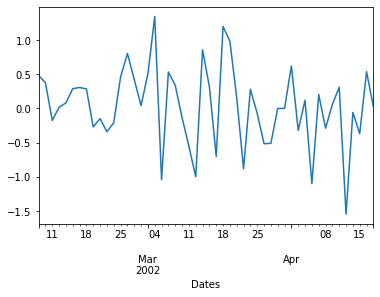

In [ ]:
logret_spblpgpt.plot()